In [46]:
import csv
file_path = './benchmark_results.csv'
models_list = ["784_56_10", "196_25_10", "196_24_14_10", "28_6_16_10_5", "14_5_11_80_10_3"]

## Prepare

In [47]:
def read_data_for_architectures(file_path, target_architectures):
    # Ensure target_architectures is a list for uniform processing
    if isinstance(target_architectures, str):
        target_architectures = [target_architectures]

    results = {arch: {} for arch in target_architectures}
    seen = {arch: set() for arch in target_architectures}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            framework = row['Framework']
            architecture = row['Architecture']
            
            for target_arch in target_architectures:
                if architecture.lower() == target_arch.lower() and framework not in seen[target_arch]:
                    seen[target_arch].add(framework)
                    results[target_arch][framework] = [
                        row['Accuracy Loss (%)'],
                        row['Avg Memory Usage (MB)'],
                        row['Std Memory Usage'],
                        row['Avg Proving Time (s)'],
                        row['Std Proving Time']
                    ]
    
    return results

In [48]:
def target_arch(model_name):
    layers = model_name.split("_")
    if int(layers[0]) < 30:
        arch = "Input-Conv2d-Conv2d" + (len(layers)-4) * "-Dense" + "_Kernal"
        layers[0] = str(int(layers[0])**2)
        target = f'{arch} ({"x".join(layers[:-1])}_{layers[-1]}x{layers[-1]})'
    else:
        layers = model_name.split("_")
        arch = "Input" + (len(layers)-1) * "-Dense"
        target = f'{arch} ({"x".join(layers)})'
    
    return target

### Combine benchmark results

In [69]:
import csv
import pandas as pd

def read_and_combine_data(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    #print ('Header:', df.head())
    
    # Data structure to hold combined results
    combined_results = []

    # Group data by Framework and Architecture for processing
    grouped = df.groupby(['Framework', 'Architecture'])
    #print (grouped)
    
    for (framework, architecture), group in grouped:
        if len(group) == 2:  # Expecting two entries per group for combination
            base = group.iloc[0]
            follow_up = group.iloc[1]
            
            # Ensure we start with the base and follow up in the correct order
            if "start from 1000" in str(follow_up['Notes']):
                base, follow_up = follow_up, base  # Swap if in wrong order
            
            combined = base.copy()
            n1, n2 = 1000, 1500
            combined['Testing Size'] = 2500
            
            # Combine the metrics
            for metric in ['Accuracy Loss (%)', 'Avg Memory Usage (MB)', 'Avg Proving Time (s)']:
                combined[metric] = (n1 * base[metric] + n2 * follow_up[metric]) / (n1 + n2)
                
            for metric in ['Std Memory Usage', 'Std Proving Time']:
                # Placeholder for standard deviation combination, here we simply copy from follow_up
                # In reality, you should calculate combined standard deviation using a proper statistical method
                combined[metric] = follow_up[metric]
                

            combined['Notes'] = "Combined 0-2500"
            combined = combined.to_dict()
            for key in combined:
                combined[key] = [combined[key]]
            new_row_df = pd.DataFrame(combined)
            df = pd.concat([df, new_row_df], ignore_index=True)

    df.to_csv(file_path, index=False)

In [70]:
file_path = './cnn_accu.csv'  # Update this to your actual file path
read_and_combine_data(file_path)

In [71]:
file_path = './cnn_dnn.csv'  # Update this to your actual file path
read_and_combine_data(file_path)

### Change layers & Value lightweight

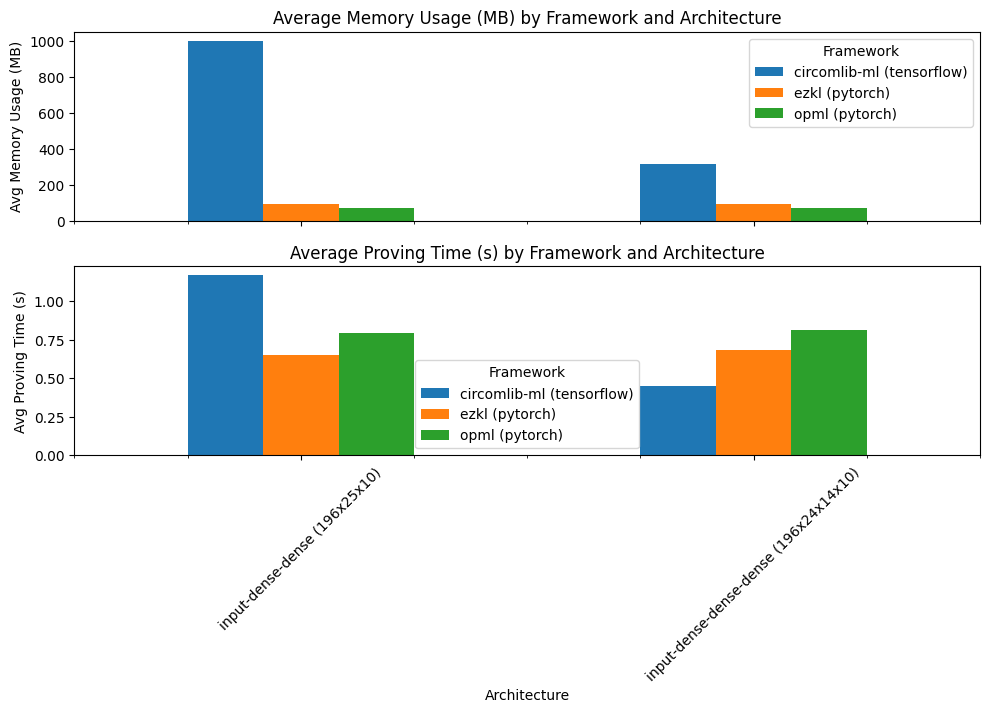

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'Framework': [
        'opml (pytorch)', 'opml (pytorch)', 
        'circomlib-ml (tensorflow)', 'circomlib-ml (tensorflow)', 
        'ezkl (pytorch)', 'ezkl (pytorch)'
    ],
    'Architecture': [
        'input-dense-dense (196x25x10)', 'input-dense-dense-dense (196x24x14x10)', 
        'Input-Dense-Dense (196x25x10)', 'Input-Dense-Dense-Dense (196x24x14x10)', 
        'Input-Dense-Dense (196x25x10)', 'Input-Dense-Dense-Dense (196x24x14x10)'
    ],
    'Avg Memory Usage (MB)': [
        72.085, 70.347, 
        998.735, 315.436, 
        91.027, 91.004
    ],
    'Avg Proving Time (s)': [
        0.795, 0.815, 
        1.169, 0.453, 
        0.654, 0.686
    ]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Convert the 'Architecture' column to lowercase
df['Architecture'] = df['Architecture'].str.lower()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Average Memory Usage Comparison
df.pivot(index='Architecture', columns='Framework', values='Avg Memory Usage (MB)').plot(kind='bar', ax=ax[0])
ax[0].set_title('Average Memory Usage (MB) by Framework and Architecture')
ax[0].set_ylabel('Avg Memory Usage (MB)')
ax[0].legend(title='Framework')

# Average Proving Time Comparison
df.pivot(index='Architecture', columns='Framework', values='Avg Proving Time (s)').plot(kind='bar', ax=ax[1])
ax[1].set_title('Average Proving Time (s) by Framework and Architecture')
ax[1].set_ylabel('Avg Proving Time (s)')
ax[1].set_xlabel('Architecture')
ax[1].legend(title='Framework')

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()


In [7]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame with all the data
df = pd.read_csv('./dnn_parm.csv')
# Normalize the metrics
df['Normalized Memory Usage'] = df.groupby('Architecture')['Avg Memory Usage (MB)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Normalized Proving Time'] = df.groupby('Architecture')['Avg Proving Time (s)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['Normalized Accuracy Loss'] = df.groupby('Architecture')['Accuracy Loss (%)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Calculate a composite score (lower is better)
df['Composite Score'] = df['Normalized Memory Usage'] + df['Normalized Proving Time'] + df['Normalized Accuracy Loss']

# Rank the frameworks within each architecture based on the composite score
df['Rank'] = df.groupby('Architecture')['Composite Score'].rank(method='dense', ascending=True)

# Sort and display the results to show the best overall framework per architecture
df_sorted = df.sort_values(by=['Architecture', 'Rank'])

# Select columns to display
columns_to_display = ['Framework', 'Architecture', 'Accuracy Loss (%)', 'Avg Memory Usage (MB)', 'Avg Proving Time (s)', 'Composite Score', 'Rank']
print(df_sorted[columns_to_display])


                   Framework                            Architecture  \
4             ezkl (pytorch)           Input-Dense-Dense (196x25x10)   
2  circomlib-ml (tensorflow)           Input-Dense-Dense (196x25x10)   
3  circomlib-ml (tensorflow)  Input-Dense-Dense-Dense (196x24x14x10)   
5             ezkl (pytorch)  Input-Dense-Dense-Dense (196x24x14x10)   
0             opml (pytorch)           input-dense-dense (196x25x10)   
1             opml (pytorch)  input-dense-dense-dense (196x24x14x10)   

   Accuracy Loss (%)  Avg Memory Usage (MB)  Avg Proving Time (s)  \
4               4.52              91.027012              0.653814   
2               0.00             998.735128              1.169482   
3               0.88             315.435559              0.452942   
5              17.68              91.003994              0.685850   
0               3.40              72.085011              0.795136   
1               3.56              70.347430              0.815495   

   Composit

### Change layers & Value lightweight

## CNN

### Best Overall

## Fix layers & Check perf diff